# Question 2 : Predicting suicidal thoughts in social media ( twitter )


*  The Aim of this notebook is predicting suicidal thoughts based on machine learnign models of paper:

https://link.springer.com/article/10.1007/s11042-023-14431-z



*   We can figure out from the conclusion of the paper that the models with Deep Learning approch worked out better than the others and can be used in text processes.


*   Model List: LSTM, 2 Layer LSTM, CNN+ 2 Layer LSTM
*   Parameters: ( such as lr and etc.) optional.





## Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

## 2-1. Pre-processing

In [3]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
file_path = '/content/drive/MyDrive/Dataset/twitter-suicidal_data.csv'
df = pd.read_csv(file_path)

In [7]:
def preprocess_text(text):
    text = text.lower()

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word.isalpha() and word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

In [8]:
print("Sample 1: (before pre-process)")
print(df['tweet'].head())

Sample 1: (before pre-process)
0    my life is meaningless i just want to end my l...
1    muttering i wanna die to myself daily for a fe...
2    work slave i really feel like my only purpose ...
3    i did something on the 2 of october i overdose...
4    i feel like no one cares i just want to die ma...
Name: tweet, dtype: object


In [9]:
df['processed_tweet'] = df['tweet'].apply(preprocess_text)
print("Sample 2: (processed)")
print(df['processed_tweet'].head())

Sample 2: (processed)
0    life meaningless want end life badly life comp...
1    muttering wan na die daily month feel worthles...
2    work slave really feel like purpose life make ...
3    something october overdosed felt alone horribl...
4     feel like one care want die maybe feel le lonely
Name: processed_tweet, dtype: object


## 2-2. Embedding matrix


Embeddings provide a way to use an efficient, dense representation in which similar vocabulary tokens have a similar encoding. They are trainable parameters (weights learned by the model during training, in the same way a model learns weights for a dense layer).

*   Split the preprocessed text into a list of words for each document
*   Train Word2Vec model
*   Use the trained Word2Vec model to obtain word embeddings





In [10]:
tokenized_tweets = [tweet.split() for tweet in df['processed_tweet']]

In [14]:
word2vec_model = Word2Vec(sentences=tokenized_tweets, vector_size=100, window=5, min_count=1, workers=4)

In [15]:
word2vec_model.save('word2vec_model.bin')

Display similar words to example words

In [18]:
loaded_word2vec_model = Word2Vec.load("word2vec_model.bin")
example_words = ['life', 'friend', 'feel', 'die', 'hate']
for word in example_words:
    similar_words = loaded_word2vec_model.wv.most_similar(word, topn=5)
    print(f"\nSimilar words to '{word}':", similar_words)


Similar words to 'life': [('everything', 0.9589766263961792), ('done', 0.95481276512146), ('nothing', 0.9536623358726501), ('worth', 0.9418818354606628), ('living', 0.9393300414085388)]

Similar words to 'friend': [('best', 0.924376368522644), ('family', 0.9066962599754333), ('girl', 0.8771329522132874), ('closest', 0.8724648952484131), ('parent', 0.8706517815589905)]

Similar words to 'feel': [('seems', 0.9075064659118652), ('belongi', 0.9074532985687256), ('feeling', 0.8915883302688599), ('look', 0.878223717212677), ('anywherei', 0.8548895716667175)]

Similar words to 'die': [('stop', 0.9466851353645325), ('end', 0.9413375854492188), ('badly', 0.9351030588150024), ('kill', 0.9328613877296448), ('diei', 0.9327409863471985)]

Similar words to 'hate': [('schlannies', 0.9416846036911011), ('weebs', 0.9353322982788086), ('reveluvs', 0.929775595664978), ('yuta', 0.9258655905723572), ('much', 0.9035629034042358)]


Obtaining word embedding matrix

In [19]:
word_to_check = 'people'
if word_to_check in word2vec_model.wv:
    embedding_example_word = word2vec_model.wv[word_to_check]
    print(f"\nWord embedding for '{word_to_check}':", embedding_example_word)
else:
    print(f"\n'{word_to_check}' not present in the vocabulary.")


Word embedding for 'people': [-1.1645441e+00  4.9270397e-01  2.1710759e-01  4.9129316e-01
  6.4192450e-04 -1.4698348e+00  5.6339223e-02  1.7478700e+00
 -7.3938352e-01 -5.4988623e-01  2.6247064e-02 -1.9032745e+00
 -1.7421402e-01  5.2516186e-01  4.0388760e-01 -9.5954603e-01
  4.2493898e-02 -8.0320013e-01 -4.4307496e-02 -1.4446636e+00
  6.0263354e-01  8.4738320e-01  9.5827377e-01 -5.8528847e-01
 -4.2008668e-01  5.5364692e-03 -4.2092732e-01 -3.5532829e-01
  1.7435099e-01 -4.2629179e-01  5.2746600e-01  3.6615059e-01
  2.4272183e-01 -2.1239163e-01  2.3049189e-01  1.5142206e+00
  1.1077726e+00 -4.7324339e-01 -7.5431854e-01 -9.1275138e-01
  5.8616984e-01 -8.2339704e-01 -6.0466927e-01  1.0422608e-01
  1.4628807e-01  4.1725710e-01 -7.6598710e-01 -3.4784308e-01
  4.6608096e-01  2.1072990e-01  3.0722722e-01 -7.8040075e-01
  5.7286543e-01  1.2939015e-01 -8.1021750e-01  8.3068073e-01
  5.6722218e-01  1.9569530e-01 -7.8343540e-01  8.1467563e-01
  3.7675187e-02 -1.9666092e-01  2.4103922e-01 -1.142786

In [20]:
vocabulary = list(word2vec_model.wv.key_to_index.keys())
print("Vocabulary of the Word2Vec model:", vocabulary)

Vocabulary of the Word2Vec model: ['want', 'dont', 'like', 'feel', 'life', 'know', 'get', 'time', 'cant', 'ive', 'friend', 'one', 'die', 'year', 'even', 'people', 'would', 'really', 'thing', 'day', 'going', 'go', 'think', 'much', 'never', 'kill', 'make', 'hate', 'help', 'way', 'see', 'anymore', 'work', 'back', 'thought', 'still', 'got', 'end', 'someone', 'anything', 'need', 'suicide', 'school', 'love', 'good', 'could', 'everything', 'nothing', 'live', 'family', 'better', 'last', 'talk', 'care', 'always', 'fucking', 'every', 'take', 'say', 'something', 'feeling', 'right', 'ever', 'keep', 'job', 'everyone', 'anyone', 'shit', 'month', 'bad', 'didnt', 'tell', 'week', 'point', 'since', 'long', 'parent', 'person', 'getting', 'tried', 'depression', 'trying', 'well', 'suicidal', 'pain', 'reason', 'around', 'try', 'away', 'wish', 'lot', 'told', 'come', 'made', 'happy', 'tired', 'find', 'enough', 'home', 'today', 'alone', 'wanted', 'best', 'give', 'hope', 'hurt', 'living', 'world', 'maybe', 'sto

## 2-3. Learning process of the DL models

In this part we are Learning three models mentioned (LSTM, 2layer LSTM , and CNN + 2layer LSTM)


*   In training phase of the CNN + 2 layer LSTM if we faced problem we can solve it using (Reshape to 3D)




1.   LSTM model



In [21]:
max_words = 5000
max_len = 100
embedding_dim = 300
lstm_units = 100
batch_size = 64
epochs = 20
learning_rate = 0.001

In [22]:
df = df.dropna(subset=['processed_tweet'])

X_train, X_test, y_train, y_test = train_test_split(df['processed_tweet'], df['intention'], test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=max_len)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_len)

In [23]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=lstm_units))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 300)          1500000   
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 1660501 (6.33 MB)
Trainable params: 1660501 (6.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
history = model.fit(X_train_padded, y_train, validation_data=(X_test_padded, y_test), batch_size=batch_size, epochs=epochs)


Epoch 1/20
114/114 [==============================] - 24s 173ms/step - loss: 0.3161 - accuracy: 0.8683 - val_loss: 0.2197 - val_accuracy: 0.9123
Epoch 2/20
114/114 [==============================] - 12s 105ms/step - loss: 0.1655 - accuracy: 0.9376 - val_loss: 0.2137 - val_accuracy: 0.9167
Epoch 3/20
114/114 [==============================] - 9s 79ms/step - loss: 0.1033 - accuracy: 0.9605 - val_loss: 0.2477 - val_accuracy: 0.9073
Epoch 4/20
114/114 [==============================] - 8s 68ms/step - loss: 0.0700 - accuracy: 0.9749 - val_loss: 0.2710 - val_accuracy: 0.9167
Epoch 5/20
114/114 [==============================] - 5s 41ms/step - loss: 0.0528 - accuracy: 0.9794 - val_loss: 0.2945 - val_accuracy: 0.9123
Epoch 6/20
114/114 [==============================] - 6s 49ms/step - loss: 0.0395 - accuracy: 0.9852 - val_loss: 0.3188 - val_accuracy: 0.9134
Epoch 7/20
114/114 [==============================] - 4s 36ms/step - loss: 0.0558 - accuracy: 0.9809 - val_loss: 0.3151 - val_accuracy: 0.

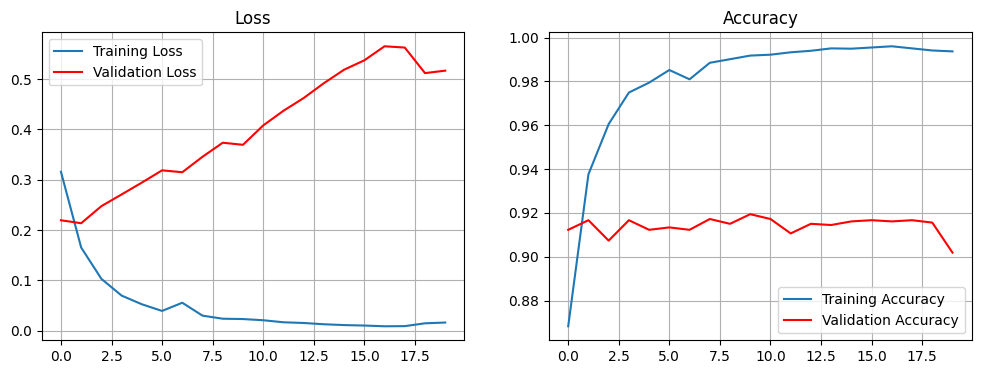

In [29]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [30]:
y_pred = model.predict(X_test_padded)
y_pred_classes = np.round(y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

classification_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes.flatten()})
print("Classification Results:")
print(classification_results.head())

57/57 [==============================] - 1s 5ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.89      0.91      1019
           1       0.87      0.92      0.89       805

    accuracy                           0.90      1824
   macro avg       0.90      0.90      0.90      1824
weighted avg       0.90      0.90      0.90      1824

Classification Results:
      Actual  Predicted
7194       1        1.0
3133       1        1.0
1446       1        1.0
7042       0        0.0
5414       0        0.0



2.   2 Layer LSTM



In [31]:
max_words = 5000
max_len = 100
embedding_dim = 300
epochs = 20
batch_size = 64
learning_rate = 0.001

In [41]:
df = df.dropna(subset=['processed_tweet', 'intention'])
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweet'], df['intention'], test_size=0.2, random_state=42)
y_test = y_test.astype(int)
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [57]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dense(units=1, activation='sigmoid'))

In [58]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 100, 300)          1500000   
                                                                 
 lstm_9 (LSTM)               (None, 100, 100)          160400    
                                                                 
 lstm_10 (LSTM)              (None, 100, 50)           30200     
                                                                 
 dense_5 (Dense)             (None, 100, 1)            51        
                                                                 
Total params: 1690651 (6.45 MB)
Trainable params: 1690651 (6.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/20
92/92 [==============================] - 16s 141ms/step - loss: 0.5378 - accuracy: 0.7336 - val_loss: 0.4968 - val_accuracy: 0.7632
Epoch

57/57 [==============================] - 0s 5ms/step - loss: 0.4961 - accuracy: 0.7699
Test Loss: 0.4961, Test Accuracy: 0.7699


<Figure size 1200x400 with 0 Axes>

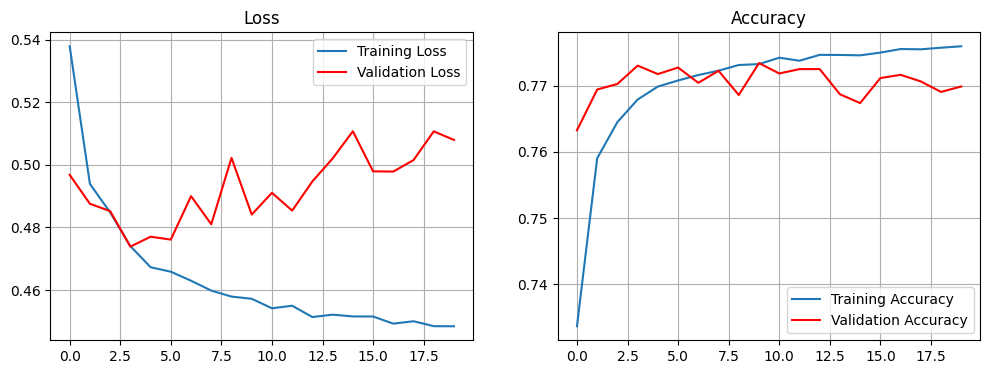

In [59]:
plt.figure(figsize=(12, 4))

loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss', color="red")
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color="red")
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.show()


In [60]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.round(y_pred)



57/57 [==============================] - 1s 4ms/step


In [68]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.round(y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

classification_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes.flatten()})
print("\nClassification Results:")
print(classification_results.head())

57/57 [==============================] - 0s 7ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1019
           1       0.88      0.89      0.89       805

    accuracy                           0.90      1824
   macro avg       0.90      0.90      0.90      1824
weighted avg       0.90      0.90      0.90      1824


Classification Results:
      Actual  Predicted
7194       1        1.0
3133       1        1.0
1446       1        1.0
7042       0        0.0
5414       0        0.0



3.   CNN + 2 Layer LSTM



In [62]:
max_words = 5000
max_len = 100
learning_rate = 0.001
batch_size = 64
epochs = 20

In [63]:
df = df.dropna(subset=['processed_tweet'])

X_train, X_test, y_train, y_test = train_test_split( df['processed_tweet'], df['intention'], test_size=0.2, random_state=42)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train.astype(str))
X_train_seq = tokenizer.texts_to_sequences(X_train.astype(str))
X_test_seq = tokenizer.texts_to_sequences(X_test.astype(str))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')

In [64]:
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=300, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1, activation='sigmoid'))

In [65]:
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.summary()
history = model.fit(X_train_pad, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.1)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 100, 300)          1500000   
                                                                 
 conv1d (Conv1D)             (None, 100, 64)           57664     
                                                                 
 max_pooling1d (MaxPooling1  (None, 50, 64)            0         
 D)                                                              
                                                                 
 lstm_11 (LSTM)              (None, 50, 100)           66000     
                                                                 
 lstm_12 (LSTM)              (None, 100)               80400     
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                      

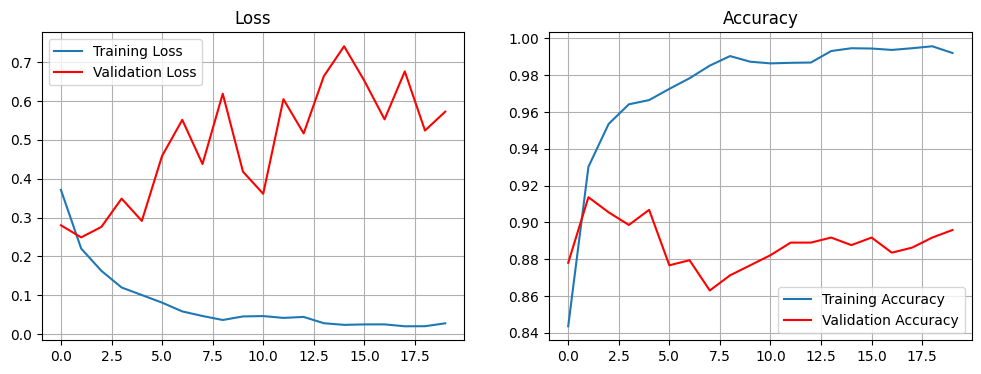

In [69]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss',color = 'red')
plt.title('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy',color = 'red')
plt.title('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

In [67]:
y_pred = model.predict(X_test_pad)
y_pred_classes = np.round(y_pred)
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

# Display classification results
classification_results = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_classes.flatten()})
print("\nClassification Results:")
print(classification_results.head())

57/57 [==============================] - 1s 4ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91      1019
           1       0.88      0.89      0.89       805

    accuracy                           0.90      1824
   macro avg       0.90      0.90      0.90      1824
weighted avg       0.90      0.90      0.90      1824


Classification Results:
      Actual  Predicted
7194       1        1.0
3133       1        1.0
1446       1        1.0
7042       0        0.0
5414       0        0.0
